In [47]:
%matplotlib inline

import pickle
import copy
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
df = pd.read_csv('./data/twitch_final_dataset.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,Source,Destination,Class,Page_Rank_Src,Page_Rank_Dst,Shortest_Path,Followers_Src,Followees_Src,Followers_Dst,Followees_Dst,Int_Followers,Int_Followees
0,6194,255,1,0.000023,0.000013,-1,0,3,0,3,0,0
1,6194,980,1,0.000023,0.000014,-1,0,3,0,15,0,1
2,6194,2992,1,0.000023,0.000024,4,0,3,2,0,0,0
3,6194,2507,1,0.000023,0.000020,3,0,3,8,13,0,0
4,6194,986,1,0.000023,0.000029,-1,0,3,0,20,0,0


<AxesSubplot:>

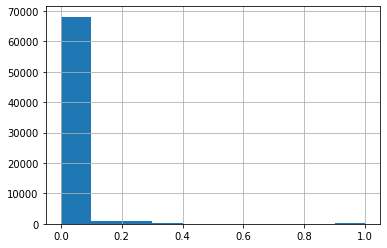

In [49]:
x = df['Page_Rank_Src']
df['Page_Rank_Src'] = ( x-x.min()) / ( x.max() - x.min() )
df['Page_Rank_Src'].hist()

<AxesSubplot:>

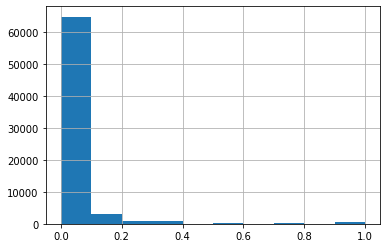

In [50]:
x = df['Page_Rank_Dst']
df['Page_Rank_Dst'] = ( x-x.min()) / ( x.max() - x.min() )
df['Page_Rank_Dst'].hist()

<AxesSubplot:>

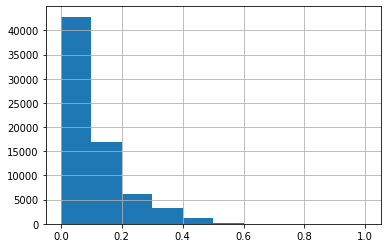

In [51]:
x = df['Shortest_Path']
df['Shortest_Path'] = ( x-x.min()) / ( x.max() - x.min() )
df['Shortest_Path'].hist()

<AxesSubplot:>

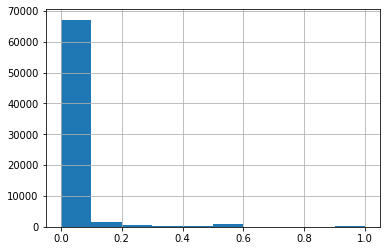

In [52]:
x = df['Followees_Dst']
df['Followees_Dst'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followees_Dst'].hist()

<AxesSubplot:>

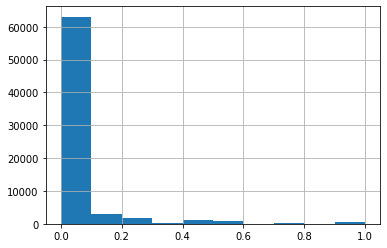

In [53]:
x = df['Followees_Src']
df['Followees_Src'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followees_Src'].hist()

<AxesSubplot:>

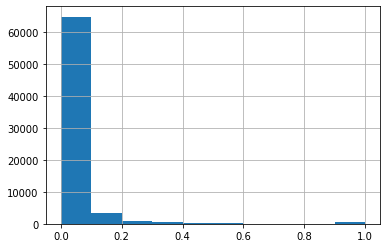

In [54]:
x = df['Followers_Dst']
df['Followers_Dst'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followers_Dst'].hist()

<AxesSubplot:>

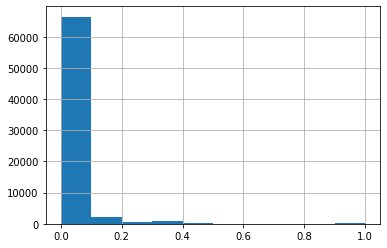

In [55]:
x = df['Followers_Src']
df['Followers_Src'] = ( x-x.min()) / ( x.max() - x.min() )
df['Followers_Src'].hist()

<AxesSubplot:>

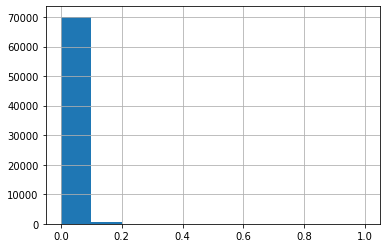

In [56]:
x = df['Int_Followees']
df['Int_Followees'] = ( x-x.min()) / ( x.max() - x.min() )
df['Int_Followees'].hist()

<AxesSubplot:>

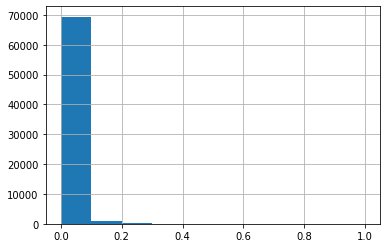

In [57]:
x = df['Int_Followers']
df['Int_Followers'] = ( x-x.min()) / ( x.max() - x.min() )
df['Int_Followers'].hist()

In [58]:
df.head(5)

,Source,Destination,Class,Page_Rank_Src,Page_Rank_Dst,Shortest_Path,Followers_Src,Followees_Src,Followers_Dst,Followees_Dst,Int_Followers,Int_Followees
0,6194,255,1,0.006865,0.001469,0.00,0.0,0.007772,0.000000,0.007772,0.0,0.000000
1,6194,980,1,0.006865,0.001998,0.00,0.0,0.007772,0.000000,0.038860,0.0,0.013158
2,6194,2992,1,0.006865,0.007285,0.20,0.0,0.007772,0.004988,0.000000,0.0,0.000000
3,6194,2507,1,0.006865,0.005517,0.16,0.0,0.007772,0.019950,0.033679,0.0,0.000000
4,6194,986,1,0.006865,0.010406,0.00,0.0,0.007772,0.000000,0.051813,0.0,0.000000


In [59]:
df.to_csv('./data/twitch_preprocessed_data.csv')

In [61]:
g = nx.from_pandas_edgelist(df[['Source','Destination']], source='Source', target='Destination',create_using=nx.DiGraph())
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 50239
Number of edges: 70648
Average in degree:   1.4062
Average out degree:   1.4062


In [62]:
df_x = df.drop(columns=['Source', 'Destination', 'Class'])
df_y = df[['Class']]
x_train, x_test, y_train, y_test  = train_test_split(df_x, df_y, test_size = 0.3, random_state=7)

## 1. Logistic Regression

In [63]:
penalty_values = ['l1', 'l2']
c_values = np.logspace(0, 4, 10)
param_grid = {'C' : c_values, 'penalty' : penalty_values}

gs_lr = GridSearchCV(cv = 10, estimator = LogisticRegression(), param_grid = param_grid)

In [66]:
start = time.time()
gs_lr.fit(x_train, y_train)
end = time.time()
print('Time taken to train model : ', round(end-start,2) , ' seconds')

Time taken to train model :  24.88  seconds


In [68]:
pickle.dump(gs_lr.best_estimator_, open('./data/twitch_lr_model.p', 'wb'))
print(gs_lr.best_params_)

{'C': 1291.5496650148827, 'penalty': 'l2'}


In [69]:
print(classification_report(gs_lr.best_estimator_.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     11223
           1       0.92      0.98      0.95      9972

    accuracy                           0.95     21195
   macro avg       0.95      0.95      0.95     21195
weighted avg       0.95      0.95      0.95     21195



In [70]:
print(confusion_matrix(gs_lr.best_estimator_.predict(x_test), y_test))

[[10321   902]
 [  199  9773]]


## 2. Random Forest

In [71]:
estimators = [50, 100, 150]
depths = [9, 12, 15, 24]
split = np.random.randint(100, 150, 2)
leaves = np.random.randint(20, 30, 2)
param_grid = {'n_estimators' : estimators, 'max_depth' : depths, 'min_samples_split' : split, 'min_samples_leaf' : leaves}

gs_rf = GridSearchCV(cv = 10, estimator = RandomForestClassifier(), param_grid = param_grid)

In [73]:
start = time.time()
gs_rf.fit(x_train, y_train) 
end = time.time()
print('Time taken to train model : ', round(end-start,2) , ' seconds')

Time taken to train model :  1108.18  seconds


In [74]:
pickle.dump(gs_rf.best_estimator_, open('./data/twitch_rf_model.p', 'wb')) 
print(gs_rf.best_params_)

{'max_depth': 15, 'min_samples_leaf': 21, 'min_samples_split': 110, 'n_estimators': 150}


In [75]:
print(classification_report(gs_rf.best_estimator_.predict(x_test), y_test)) 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10758
           1       0.96      0.98      0.97     10437

    accuracy                           0.97     21195
   macro avg       0.97      0.97      0.97     21195
weighted avg       0.97      0.97      0.97     21195



In [76]:
print(confusion_matrix(gs_rf.best_estimator_.predict(x_test), y_test))

[[10308   450]
 [  212 10225]]


## 3. SVM

In [77]:
kernels = ['rbf', 'linear']
c_values = [0.001, 0.01, 0.1, 1]
param_grid = {'kernel':kernels, 'C':c_values}

gs_svm = GridSearchCV(cv=10, estimator=svm.SVC(), param_grid=param_grid)

In [78]:
start = time.time()
gs_svm.fit(x_train, y_train)
end = time.time()
print('Time taken to train model : ', round(end-start,2) , ' seconds')

Time taken to train model :  2897.17  seconds


In [79]:
pickle.dump(gs_svm.best_estimator_, open('./data/twitch_svm_model.p', 'wb'))
print(gs_svm.best_params_)

{'C': 1, 'kernel': 'rbf'}


In [80]:
print(classification_report(gs_svm.best_estimator_.predict(x_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     10999
           1       0.93      0.97      0.95     10196

    accuracy                           0.95     21195
   macro avg       0.95      0.95      0.95     21195
weighted avg       0.95      0.95      0.95     21195



In [81]:
print(confusion_matrix(gs_svm.best_estimator_.predict(x_test), y_test))

[[10242   757]
 [  278  9918]]
